# Game Flow Incorporating Momentum
Takes in the game flow array of probabilities and modifies them according to various explanatory variables.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import itertools # for shortening double-loop code.
%matplotlib inline
plt.style.use('ggplot')

In [13]:
# Functions

# Probability Functions

# Find the probability of winning a game given probability winning a point
def prob_hold(p):
    """Probability server holds."""
    q = 1-p
    return (
        p**4 +
        4*(p**4)*q + 
        10*(p**4)*(q**2) + 
        (20*(p**3)*(q**3)) * ((p**2)/(1 - 2*p*q))
    )

# Find the probability of winning a set given probability winning a game
def prob_win_set(ps):
    """Probability server holds."""
    qs = 1-ps
    return (
        ps**6 +
        6*(ps**6)*qs + 
        21*(ps**6)*(qs**2) + 
        56*(ps**6)*(qs**3) +
        126*(ps**6)*(qs**4) +
        42*(ps**7)*(qs**5) +
        924*(ps**7)*(qs**6)
    )

# Find the probability of winning a match given probability winning a set
def prob_win_match(pm):
    """Probability server holds."""
    qm = 1-pm
    return (
        pm**3 +
        3*(pm**3)*qm + 
        6*(pm**3)*(qm**2)
    )

def get_serve_probability(match_data, player):
    serve_no = match_data['server'].values
    point_victor = match_data['point_victor'].values

    serve_point_won = 0
    num_serves = 0

    p_array = []

    for index in range(len(serve_no)):
        if player == serve_no[index]:
            num_serves += 1

            if player == point_victor[index]:
                serve_point_won += 1

        if num_serves == 0:
            p_array.append(0)
        else:
            p_array.append(serve_point_won / num_serves)

    return p_array

def prob_win_independent_game(p1, p2):
    p1_holds_game = prob_hold(p1)
    p1_concedes_game = (1 - p1_holds_game)

    p2_holds_game = prob_hold(p2)
    p2_concedes_game = (1 - p2_holds_game)

    ps1 = (p1_holds_game + p2_concedes_game) / 2 # Prob p1 wins any independent game
    ps2 = (p2_holds_game + p1_concedes_game) / 2 # Prob p2 wins any independent game

    return ps1, ps2

# Momentum Modifier Functions

# change probability if player wins set
def modify_momentum(match_data, probability_array, player, r=1.3, q=0.4):
    '''
    When a player wins a set their "points" will increase by an exponential amount. When they lose a set their "points" will decrease but this change isn't as significant.
    '''
    # n = number of sets won
    n = 0
    lost = 0
    loss_factor = 1
    #x = 1.25

    for index in range(len(probability_array)):
        set_victor_array = match_data['set_victor'].values
        won_set = set_victor_array[index] == player

        if (won_set):
            n += 1
            n = n
        elif set_victor_array[index] == 3 - player:
            lost += 1
            # probability_array[index] = probability_array[index]/(2*lost)
            loss_factor = 1 + (q * lost)

        probability_array[index] = (((r**n)-1)/(r**n) + (1/(r**n))*probability_array[index]) ** loss_factor
        

    return probability_array

def modify_momentum_err(match_data, momentum_array, player, s=0.0035):
    '''
    Calculates the total number of unforced errors for a player and their opponent. For each additional unforced error a player commits, they will lose 0.0035 "points.
    For each additional unfrced error their opponent commits, they will gain 0.0035 "points".
    '''

    # unforced error total
    n = 0
    m = 0

    unf_err_array = match_data[f'p{player}_unf_err'].values
    for index in range(len(momentum_array)):
        unf_err = unf_err_array[index] == 1

        if (unf_err):
            n += 1

    unf_err_array_2 = match_data[f'p{3-player}_unf_err'].values
    for index in range(len(momentum_array)):
        unf_err_2 = unf_err_array_2[index] == 1

        if (unf_err_2):
            m += 1

        if n>= 0:
            momentum_array[index] = momentum_array[index]-s*n + s*m
            if momentum_array[index] < 0:
                momentum_array[index] = 0
    return momentum_array

def points_scored(match_data, points_array, player, uu= 1.005, cc=0.0001):
    '''
    When a player wins a set their "points" will increase by an exponential amount. When they lose a set their "points" will decrease but this change isn't as significant.
    '''
    # w = number of points won
    ww = 0
    mm = 0
    lost_factor=1

    for index in range(len(points_array)):
        points_victor_array = match_data['point_victor'].values
        won_point = points_victor_array[index] == player

        if (won_point):
            ww += 1
    
    for index in range(len(points_array)):
        points_loss_array = match_data['point_victor'].values
        lost_point = points_loss_array[index] == 3 - player

        if (lost_point):
            mm += 1
            lost_factor = 1 + (mm * cc)

            
        points_array[index] = (((uu**ww)-1)/(uu**ww) + (1/(uu**ww)))*points_array[index]-mm*cc
        

    return points_array

In [45]:
# 1 - Calculate serve probability (points_on_serves / total serves)
# 2 - Calculate probability of winning a game from serve probability for each player
# 3 - Calculate probability of winning a set from the player win game probability
# 4 - Calculate probability of winning a match from the player win set probability
# 5 - Graph the probability of winning the set as point values increase
import numpy as np

class MarkovChain:
    def __init__(self, raw_data, match_to_examine, rv=1.25, sv=0.005, qv =0.4, uuv = 1.005, ccv =0.0001 ):
        self.match = raw_data[raw_data['match_id'] == match_to_examine]
        self.player1_name = self.match['player1'].values[0]
        self.player2_name = self.match['player2'].values[0]
        self.max_length = 0
        self.p1_momentum = []
        self.p2_momentum = []

        self.sv = sv
        self.rv = rv
        self.qv = qv
        self.uuv = uuv
        self.ccv = ccv

    # 1 - Get serve probabilities
    def get_serve_probabilities(self, debug=False):
        p1_probability = get_serve_probability(self.match, 1)
        p2_probability = get_serve_probability(self.match, 2)
    
        if debug:
            print("Probability of winning a serve")
            print(p1_probability)
            print(p2_probability)
    
        # Get the maximum length between both probability arrays
        self.max_length = max(len(p1_probability), len(p2_probability))

        return p1_probability, p2_probability
    

    #  2 - Get probability of winning the game
    def get_game_probabilities(self, p1_probability, p2_probability, debug=False):
        pg1_array = []
        pg2_array = []

        for index in range(self.max_length):
            pg1, pg2 = prob_win_independent_game(p1_probability[index], p2_probability[index])

            pg1_array.append(pg1)
            pg2_array.append(pg2)

        if debug:
            print("Probability of winning the game")
            print(pg1_array)
            print(pg2_array)

        return pg1_array, pg2_array
    
    # 3 - Get probability of winning the set.
    def get_set_probabilities(self, pg1_array, pg2_array, debug=False):
        ps1_array = []
        ps2_array = []

        for index in range(self.max_length):
            ps1_array.append(prob_win_set(pg1_array[index]))
            ps2_array.append(prob_win_set(pg2_array[index]))

        if debug:
            print("Probability of winning the set")
            print(ps1_array)
            print(ps2_array)

        return ps1_array, ps2_array
    
    # 4 - Get probability of winning the match
    def get_match_probabilities(self, ps1_array, ps2_array, debug=False):
        #pm1_array = []
        #pm2_array = []

        pm1_array = np.zeros(self.max_length)
        pm2_array = np.zeros(self.max_length)
        
        for index in range(self.max_length):
            #pm1_array.append(prob_win_match(ps1_array[index]))
            #pm2_array.append(prob_win_match(ps2_array[index]))
            pm1_array[index] = prob_win_match(ps1_array[index])
            pm2_array[index] = prob_win_match(ps2_array[index])
            

        if debug:
            print("Probability of winning the match")
            print(pm1_array)
            print(pm2_array)

        return pm1_array, pm2_array
    
    def update_momentum(self, pm1_array, pm2_array, debug=False):
        
        
        p1_momentum = modify_momentum(self.match,  pm1_array, 1, r=self.rv, q=self.qv)
        p2_momentum = modify_momentum(self.match, pm2_array, 2, r=self.rv, q=self.qv)

        p1_momentum1 = modify_momentum_err(self.match, p1_momentum, 1, s=self.sv)
        p2_momentum2 = modify_momentum_err(self.match, p2_momentum, 2, s=self.sv)

        p1_momentum11 = points_scored(self.match, p1_momentum1, 1, uu=self.uuv, cc=self.ccv)
        p2_momentum22 = points_scored(self.match, p2_momentum2, 2, uu=self.uuv, cc=self.ccv)

        if debug:
            print(p1_momentum1)
            print(p2_momentum2)

        return p1_momentum11, p2_momentum22
    
    # 5 - Graph
    def graph_momentum(self):
        # graph the performance of match flow + momentum
        set_change_points = []

        
        old_entry = 1
        for index, entry in enumerate(self.match['set_no']):
            if entry != old_entry:
                set_change_points.append(index + 1)
                old_entry = entry

        plt.title("Game Flow")
        plt.plot(range(len(self.p1_momentum)), self.p1_momentum, color="red", label=f"{self.player1_name}")
        plt.plot(range(len(self.p2_momentum)), self.p2_momentum, color="blue", label=f"{self.player2_name}")
        plt.xlabel("Point Number")
        plt.ylabel("Performance Rate")
        plt.legend()

        plt.text(20, -.04, 'Set 1', verticalalignment='bottom')
        for index, value in enumerate(set_change_points):
            plt.axvline(x=value, color='gray', linestyle='--')
            plt.text(value + 20, -.04, f"Set {index + 2}", verticalalignment='bottom')

        plt.show()

    def prediction(self, verbose=False):
        # Find who was performing better before sets 3 4 and 5
        set_change_points = []


        old_entry = 1
        for index, entry in enumerate(self.match['set_no']):
            if entry != old_entry:
                set_change_points.append(index + 1)
                old_entry = entry
        for index, value in enumerate(set_change_points):
            if index == 1:
                if self.p1_momentum[value] > self.p2_momentum[value]:
                    set_3_pred = self.player1_name
                    if verbose:
                        print(self.player1_name, "is winning going into set 3 with: ", self.p1_momentum[value], "momentum")
                else:
                    set_3_pred = self.player2_name
                    if verbose:
                        print(self.player2_name, "is winning going into set 3 with: ", self.p2_momentum[value], "momentum")

            elif index == 2:
                if self.p1_momentum[value] > self.p2_momentum[value]:
                    set_4_pred = self.player1_name
                    if verbose:
                        print(self.player1_name, "is winning going into set 4 with: ", self.p1_momentum[value], "momentum")
                else:
                    set_4_pred = self.player2_name
                    if verbose:
                        print(self.player2_name, "is winning going into set 4 with: ", self.p2_momentum[value], "momentum")

            elif index == 3:
                if self.p1_momentum[value] > self.p2_momentum[value]:
                    set_5_pred = self.player1_name
                    if verbose:
                        print(self.player1_name, "is winning going into set 5 with: ", self.p1_momentum[value], "momentum")
                elif self.p1_momentum[value] < self.p2_momentum[value]:
                    set_5_pred = self.player2_name
                    if verbose:
                        print(self.player2_name, "is winning going into set 5 with: ", self.p2_momentum[value], "momentum")
                else: 
                    set_5_pred = 0

        set_victors = self.match['set_victor']
        final_point = set_victors.iloc[-1]
        if final_point == 1:
            winner = self.player1_name
        else:
            winner = self.player2_name
        if verbose:
            print(winner, "won the game")

        
        if verbose:
            for index, value in enumerate(set_change_points):
                if index == 1:
                    if winner == set_3_pred:
                        print("set 3 prediction is correct")
                    else:
                        print("set 3 prediction is wrong")
    
                elif index == 2:
                    if winner == set_4_pred:
                        print("set 4 prediction is correct")
                    else:
                        print("set 4 prediction is wrong")
                        
                elif index == 3:
                    if winner == set_5_pred:
                        print("set 5 prediction is correct")
                    else:
                        print("set 5 prediction is wrong")
            #

        self.set_change_points = set_change_points
        
        data = np.vstack([self.p1_momentum[self.set_change_points], self.p2_momentum[self.set_change_points]])
        data = data.T
        
        result_array = self.determine_results(data, final_point)

        return result_array
        # return data, final_point
        
    #
    
    def train(self, debug=False):
        # possible optimizable?
        #self.p1_momentum, self.p2_momentum = self.update_momentum(
        #    *self.get_match_probabilities( # 4
        #        *self.get_set_probabilities( # 3
        #            *self.get_game_probabilities( # 2
        #                *self.get_serve_probabilities(debug), debug), debug), debug), debug) # 1

        a = self.get_serve_probabilities(debug)
        b = self.get_game_probabilities(*a, debug)
        c = self.get_set_probabilities(*b, debug)
        d = self.get_match_probabilities(*c, debug)
        self.p1_momentum, self.p2_momentum = self.update_momentum(*d, debug)
        
        
        self.p1_momentum = np.array(self.p1_momentum)
        self.p2_momentum = np.array(self.p2_momentum)
        return
    
    def determine_results(self, data, win, verbose=False):
        predicted_winner = 1+(np.diff(data, axis=1) )

        actual_winner = win*np.ones( np.shape(predicted_winner) )

        winner_number = actual_winner-1
        #winner_number

        #
        # possible to optimize?
        #
        equal_elements = []
        #for i in range(len(predicted_winner)):
        #    if math.floor(predicted_winner[i][0]) == winner_number[i][0]:
        #        equal_elements.append( i+2 )
        
        # n-by-1 boolean array (True means predicted correctly)
        equal_elements = np.floor(predicted_winner) == winner_number
        
        #equal_elements = [i + 2 for i in range(len(predicted_winner)) if math.floor(predicted_winner[i]) == winner_number[i]]
        #import pdb
        #pdb.set_trace()

        
        #match_total_sets = len(predicted_winner)+1
        #match_length = [i for i in range(2, match_total_sets+1)]
        #result_array = np.vstack([1 if elem in equal_elements else 0 for elem in match_length])

        result_array = equal_elements.astype(int)
        
        # result_array : should have a 1 for every set which is predicted correctly; otherwise 0.
        #
        # end optimizable.
        #

        if verbose:
            print("The length of the match is:", len(predicted_winner)+1 )
            print(result_array)

        return result_array

In [46]:
if False:
    # 2023 Matches
    FILE = '2023-wimbledon-data.csv'
    MATCHES_TO_EXAMINE = ['2023-wimbledon-1301', '2023-wimbledon-1302', '2023-wimbledon-1303', '2023-wimbledon-1304', '2023-wimbledon-1305','2023-wimbledon-1306','2023-wimbledon-1307','2023-wimbledon-1308','2023-wimbledon-1309',
                        '2023-wimbledon-1310','2023-wimbledon-1311','2023-wimbledon-1312','2023-wimbledon-1313','2023-wimbledon-1314','2023-wimbledon-1315','2023-wimbledon-1316','2023-wimbledon-1401','2023-wimbledon-1402',
                        '2023-wimbledon-1403','2023-wimbledon-1404','2023-wimbledon-1405','2023-wimbledon-1406','2023-wimbledon-1407','2023-wimbledon-1408','2023-wimbledon-1501','2023-wimbledon-1502','2023-wimbledon-1503',
                        '2023-wimbledon-1504','2023-wimbledon-1601','2023-wimbledon-1602','2023-wimbledon-1701']
if True:
    # 2021 Matches
    FILE = '2021-wimbledon-data.csv'
    MATCHES_TO_EXAMINE = [
                        '2021-wimbledon-1147','2021-wimbledon-1101', '2021-wimbledon-1102', '2021-wimbledon-1103', '2021-wimbledon-1104', '2021-wimbledon-1105',
                        '2021-wimbledon-1106', '2021-wimbledon-1107', '2021-wimbledon-1108', '2021-wimbledon-1109', '2021-wimbledon-1110',
                        '2021-wimbledon-1111', '2021-wimbledon-1112', '2021-wimbledon-1113', '2021-wimbledon-1114', '2021-wimbledon-1115',
                        '2021-wimbledon-1116', '2021-wimbledon-1117', '2021-wimbledon-1118', '2021-wimbledon-1119', '2021-wimbledon-1120',
                        '2021-wimbledon-1121', '2021-wimbledon-1122', '2021-wimbledon-1123', '2021-wimbledon-1124', '2021-wimbledon-1125',
                        '2021-wimbledon-1126', '2021-wimbledon-1127', '2021-wimbledon-1128', '2021-wimbledon-1129', '2021-wimbledon-1130',
                        '2021-wimbledon-1131', '2021-wimbledon-1132', '2021-wimbledon-1133', '2021-wimbledon-1134', '2021-wimbledon-1135',
                        '2021-wimbledon-1136', '2021-wimbledon-1137', '2021-wimbledon-1138', '2021-wimbledon-1139', '2021-wimbledon-1140',
                        '2021-wimbledon-1141', '2021-wimbledon-1142', '2021-wimbledon-1143', '2021-wimbledon-1144', '2021-wimbledon-1145',
                        '2021-wimbledon-1146',  '2021-wimbledon-1148', '2021-wimbledon-1150', '2021-wimbledon-1151', 
                        '2021-wimbledon-1152', '2021-wimbledon-1153', '2021-wimbledon-1154', '2021-wimbledon-1155', '2021-wimbledon-1156', 
                        '2021-wimbledon-1157', '2021-wimbledon-1158', '2021-wimbledon-1159', '2021-wimbledon-1160', '2021-wimbledon-1161', 
                        '2021-wimbledon-1162', '2021-wimbledon-1163', '2021-wimbledon-1164', '2021-wimbledon-1201', '2021-wimbledon-1202', 
                        '2021-wimbledon-1203', '2021-wimbledon-1204', '2021-wimbledon-1205', '2021-wimbledon-1206', '2021-wimbledon-1207', 
                        '2021-wimbledon-1208', '2021-wimbledon-1209', '2021-wimbledon-1210', '2021-wimbledon-1211', '2021-wimbledon-1212', 
                        '2021-wimbledon-1214', '2021-wimbledon-1215', '2021-wimbledon-1216', '2021-wimbledon-1217', '2021-wimbledon-1218', 
                        '2021-wimbledon-1219', '2021-wimbledon-1220', '2021-wimbledon-1221', '2021-wimbledon-1222', '2021-wimbledon-1223', 
                        '2021-wimbledon-1224', '2021-wimbledon-1225', '2021-wimbledon-1226', '2021-wimbledon-1227', '2021-wimbledon-1228', 
                        '2021-wimbledon-1229', '2021-wimbledon-1230', '2021-wimbledon-1231', '2021-wimbledon-1232', '2021-wimbledon-1301', 
                        '2021-wimbledon-1302', '2021-wimbledon-1303', '2021-wimbledon-1304', '2021-wimbledon-1305', '2021-wimbledon-1306', 
                        '2021-wimbledon-1307', '2021-wimbledon-1308', '2021-wimbledon-1309', '2021-wimbledon-1310', '2021-wimbledon-1311', 
                        '2021-wimbledon-1312', '2021-wimbledon-1313', '2021-wimbledon-1314', '2021-wimbledon-1315', '2021-wimbledon-1316', 
                        '2021-wimbledon-1401', '2021-wimbledon-1402', '2021-wimbledon-1403', '2021-wimbledon-1404', '2021-wimbledon-1405', 
                        '2021-wimbledon-1406', '2021-wimbledon-1407', '2021-wimbledon-1408', '2021-wimbledon-1501', '2021-wimbledon-1502', 
                        '2021-wimbledon-1503', '2021-wimbledon-1504', '2021-wimbledon-1601', '2021-wimbledon-1602', '2021-wimbledon-1701']
if False:
    FILE = '2021-wimbledon-data.csv'
    # 2021 matches of 5 sets
    MATCHES_TO_EXAMINE = [
                        '2021-wimbledon-1104', '2021-wimbledon-1105', '2021-wimbledon-1107', '2021-wimbledon-1108', 
                        '2021-wimbledon-1122', '2021-wimbledon-1123', '2021-wimbledon-1125', '2021-wimbledon-1126', 
                        '2021-wimbledon-1127', '2021-wimbledon-1136', '2021-wimbledon-1140', '2021-wimbledon-1142', 
                        '2021-wimbledon-1144', '2021-wimbledon-1158', '2021-wimbledon-1163', '2021-wimbledon-1214',
                        '2021-wimbledon-1215', '2021-wimbledon-1216', '2021-wimbledon-1223', '2021-wimbledon-1316', 
                        '2021-wimbledon-1402', '2021-wimbledon-1403', '2021-wimbledon-1406', '2021-wimbledon-1408', 
                        '2021-wimbledon-1502']

raw_data = pd.read_csv(FILE)

num = 5

rvalues = np.linspace(1, 1.8, num)
svalues = np.linspace(0, 0.006, num)
qvalues = np.linspace(0.01, 1, num)
uuvalues = np.linspace(1, 1.005, num)
ccvalues = np.linspace(0., 0.001, num)

results = np.zeros( (num, num) )

# CODE TO BE AUTOMATED/TESTED OVER PARAM VALUES.
#if True: 
for i,j in itertools.product( range(num), range(num) ):
    set1_correct = set1_total = set2_correct = set2_total = set3_correct = set3_total = set4_correct = set4_total = 0
    
    # 
    
    print(i,j)
    
    for MATCH_TO_EXAMINE in MATCHES_TO_EXAMINE:
        # TODO: redesign code so that files get loaded *once*, outside the loop.
        model = MarkovChain(raw_data, MATCH_TO_EXAMINE,  uuv=uuvalues[j]  , ccv=ccvalues[i])
        model.train()
        #if i == 0 and j == 0:
        #     model.graph_momentum()
        result_array = model.prediction()
    
        try:
            set1_correct += result_array[0,0]
            set1_total += 1
    
            set2_correct += result_array[1,0]
            set2_total += 1
    
            set3_correct += result_array[2,0]
            set3_total += 1
    
            set4_correct += result_array[3,0]
            set4_total += 1
        finally:
            continue
    results[i,j] = set4_correct/set4_total # store prediction rate.
    
if False:
    print(rvalues[i], svalues[j])
    print(f"Predicted winner at set 2 correctly {set1_correct} / {set1_total} times")
    print(f"Predicted winner at set 3 correctly {set2_correct} / {set2_total} times")
    print(f"Predicted winner at set 4 correctly {set3_correct} / {set3_total} times")
    print(f"Predicted winner at set 5 correctly {set4_correct} / {set4_total} times")
    
    results[i,j] = set4_correct/set4_total # store prediction rate

0 0
1.0 0.0 74
1.0 0.0 73
1.0 0.0 113
1.0 0.0 74
1.0 0.0 132
1.0 0.0 143
1.0 0.0 153
1.0 0.0 142
1.0 0.0 159
1.0 0.0 150
1.0 0.0 171
1.0 0.0 151
1.0 0.0 123
1.0 0.0 94
1.0 0.0 122
1.0 0.0 115
1.0 0.0 160
1.0 0.0 174
1.0 0.0 97
1.0 0.0 64
1.0 0.0 65
1.0 0.0 97
1.0 0.0 102
1.0 0.0 83
1.0 0.0 143
1.0 0.0 128
1.0 0.0 72
1.0 0.0 57
1.0 0.0 114
1.0 0.0 116
1.0 0.0 128
1.0 0.0 113
1.0 0.0 97
1.0 0.0 121
1.0 0.0 84
1.0 0.0 97
1.0 0.0 64
1.0 0.0 94
1.0 0.0 131
1.0 0.0 119
1.0 0.0 128
1.0 0.0 136
1.0 0.0 104
1.0 0.0 80
1.0 0.0 159
1.0 0.0 160
1.0 0.0 158
1.0 0.0 169
1.0 0.0 163
1.0 0.0 144
1.0 0.0 156
1.0 0.0 155
1.0 0.0 229
1.0 0.0 218
1.0 0.0 210
1.0 0.0 182
1.0 0.0 138
1.0 0.0 115
1.0 0.0 82
1.0 0.0 105
1.0 0.0 135
1.0 0.0 117
1.0 0.0 118
1.0 0.0 131
1.0 0.0 108
1.0 0.0 120
1.0 0.0 112
1.0 0.0 88
1.0 0.0 142
1.0 0.0 118
1.0 0.0 56
1.0 0.0 87
1.0 0.0 151
1.0 0.0 155
1.0 0.0 99
1.0 0.0 120
1.0 0.0 96
1.0 0.0 113
1.0 0.0 105
1.0 0.0 85
1.0 0.0 157
1.0 0.0 155
1.0 0.0 104
1.0 0.0 71
1.0 0.0 178
1

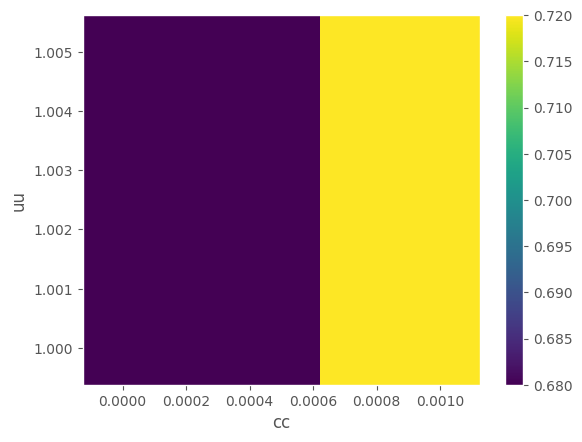

In [47]:
# visualize results of parameter sweep.
fig,ax = plt.subplots()
cax = ax.pcolor(ccvalues, uuvalues, results.T)
ax.set(xlabel='cc', ylabel='uu')
fig.colorbar(cax)

In [8]:
results.T

array([[0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2]])

In [9]:
uuvalues

array([1.     , 1.00125, 1.0025 , 1.00375, 1.005  ])

In [27]:
set4_total

25